In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.display import display
from pathlib import Path
from PIL import Image
import os

# set current path to $HOME/Projects/ocean-relic/
current_path = Path(os.path.expandvars('$HOME/Projects/ocean-relic/'))

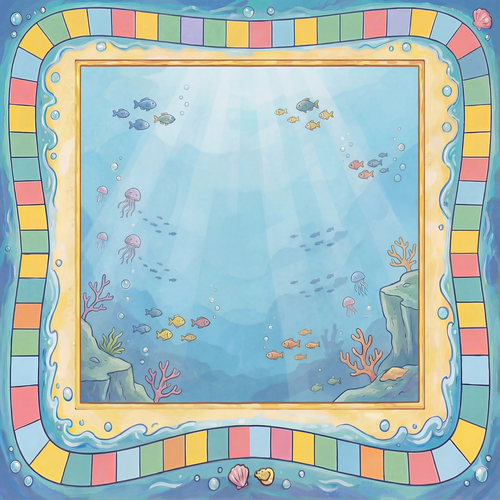

In [2]:
def display_image(img: Image.Image | Path, target_width: int | None = None):
    if isinstance(img, Path):
        img = Image.open(img)

    if target_width is not None:
        # Calculate target height to preserve aspect ratio
        width_percent = target_width / float(img.width)
        target_height = int((float(img.height) * float(width_percent)))
        img = img.resize((target_width, target_height), Image.LANCZOS)

    display(img)

# load the image
base_board_path = current_path / 'src/assets/base-board.jpeg'
base_board = Image.open(base_board_path)

ocean_scene_path = current_path / 'src/assets/ocean-scene.jpeg'
ocean_scene = Image.open(ocean_scene_path)

def overlay_ocean_scene_on_board(
    base: Image.Image,
    overlay: Image.Image,
    scale_ratio: float,
    y_offset: int,
) -> Image.Image:
    """
    Resize the ocean scene (overlay) and paste it onto the center of the base board.
    
    Args:
        base: The base board image (PIL.Image).
        overlay: The ocean scene image (PIL.Image).
        scale_ratio: The ratio of overlay size to the base board (0.0 < scale_ratio <= 1.0).
    
    Returns:
        A new Image.Image with overlay composited on the base.
    """
    # Calculate new overlay size to fit the scale ratio relative to base
    target_width = int(base.width * scale_ratio)
    width_percent = target_width / float(overlay.width)
    target_height = int((float(overlay.height) * float(width_percent)))
    overlay_resized = overlay.resize((target_width, target_height), Image.LANCZOS)
    
    # Calculate position (offset) to center overlay on base (after resize)
    offset_x = (base.width - overlay_resized.width) // 2
    offset_y = (base.height - overlay_resized.height) // 2 - y_offset
    
    # Create a copy so as not to mutate original base
    composite = base.copy()
    # Ensure overlay has alpha if needed for transparency
    if overlay_resized.mode != "RGBA":
        overlay_resized = overlay_resized.convert("RGBA")
    
    composite.paste(overlay_resized, (offset_x, offset_y), overlay_resized)
    return composite

# Example usage with display output
composite_img = overlay_ocean_scene_on_board(base_board, ocean_scene, scale_ratio=0.7, y_offset=126)
composite_img.save(current_path / 'src/assets/composite-board.jpeg')
display_image(composite_img, target_width=500)


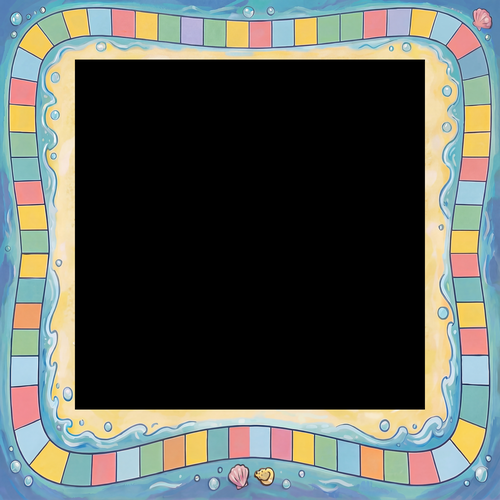

In [9]:
# Create a pure black image with the same size as base_board
black_img = Image.new("RGB", base_board.size, color=(0, 0, 0))

# Use overlay_ocean_scene_on_board to overlay the ocean scene on the black image
composite_on_black = overlay_ocean_scene_on_board(base_board, black_img, scale_ratio=0.7, y_offset=126)

composite_on_black.save(current_path / 'src/assets/composite-board-black.jpeg')
# Visualize the result
display_image(composite_on_black, target_width=500)


Matplotlib is building the font cache; this may take a moment.


Detected 251 blocks using edge detection


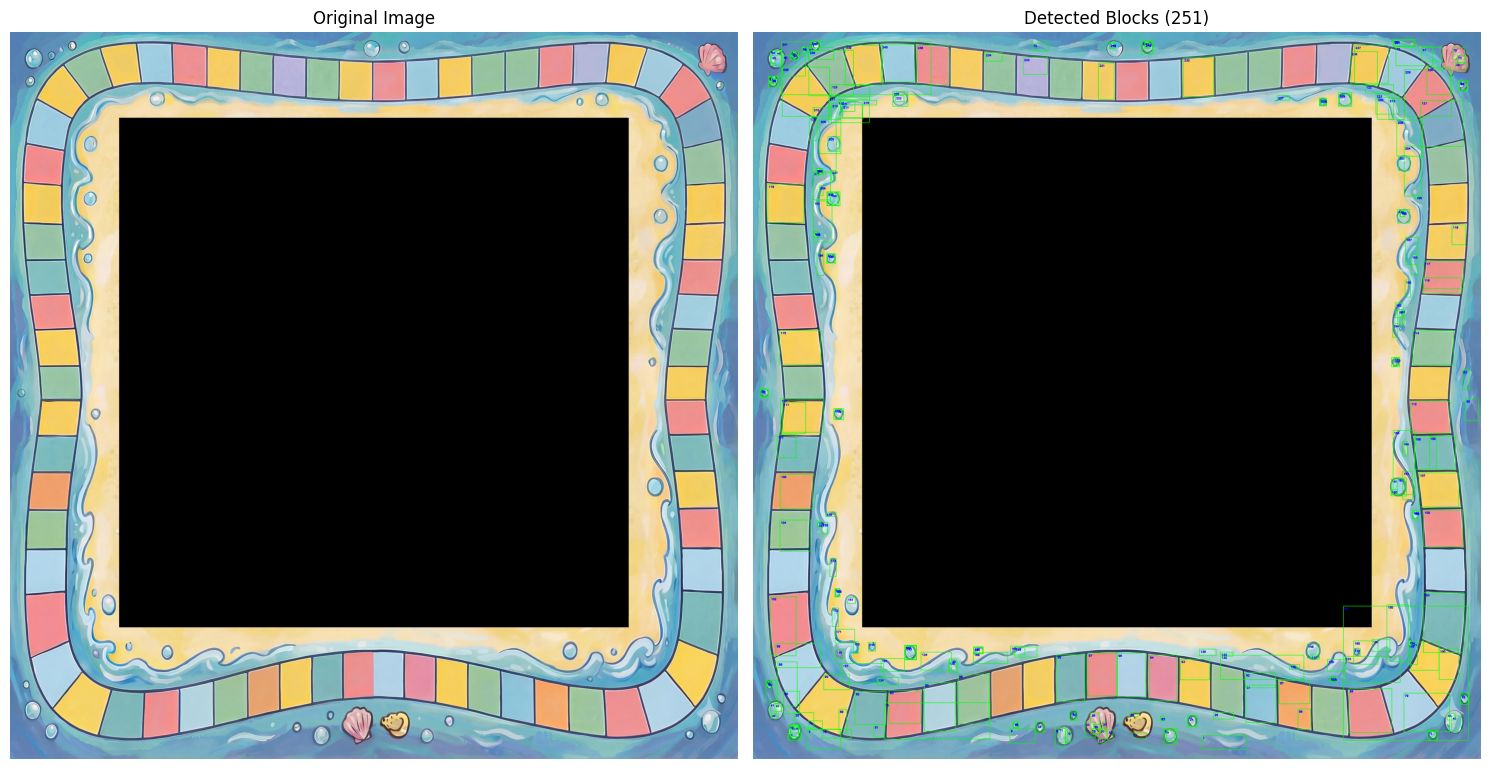


Block Coordinates (x, y, width, height):
Block 1: (2525, 3964, 250, 78)
Block 2: (3797, 3933, 54, 55)
Block 3: (3806, 3938, 38, 40)
Block 4: (307, 3927, 185, 110)
Block 5: (2308, 3923, 77, 89)
Block 6: (2316, 3929, 63, 71)
Block 7: (2325, 3935, 47, 58)
Block 8: (1700, 3923, 56, 101)
Block 9: (1445, 3923, 141, 84)
Block 10: (1760, 3938, 27, 66)
Block 11: (1718, 3919, 52, 83)
Block 12: (197, 3948, 73, 42)
Block 13: (201, 3901, 64, 80)
Block 14: (207, 3906, 51, 66)
Block 15: (210, 3912, 45, 56)
Block 16: (229, 3909, 15, 21)
Block 17: (1588, 3886, 53, 63)
Block 18: (1596, 3899, 37, 40)
Block 19: (1464, 3886, 30, 35)
Block 20: (1467, 3889, 23, 29)
Block 21: (2291, 3855, 22, 26)
Block 22: (2293, 3856, 19, 24)
Block 23: (2444, 3850, 56, 64)
Block 24: (2452, 3859, 37, 51)
Block 25: (233, 3835, 109, 85)
Block 26: (2591, 3833, 112, 38)
Block 27: (2135, 3948, 77, 32)
Block 28: (2119, 3835, 46, 23)
Block 29: (1781, 3824, 43, 54)
Block 30: (1791, 3833, 25, 37)
Block 31: (1940, 3980, 40, 25)
Block 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_track_blocks(image_path):
    """
    Detect colored blocks around a board game track.
    
    Parameters:
    -----------
    image_path : str
        Path to the input image
    
    Returns:
    --------
    blocks : list
        List of detected block coordinates (x, y, w, h)
    """
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    height, width = img.shape[:2]
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use adaptive thresholding to detect edges between blocks
    # This works better than simple threshold for varying lighting
    thresh = cv2.adaptiveThreshold(blurred, 255, 
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    
    # Invert so blocks are white on black background
    thresh = cv2.bitwise_not(thresh)
    
    # Find contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, 
                                          cv2.CHAIN_APPROX_SIMPLE)
    
    # Define track region parameters (adjust based on your image)
    # The track is around the border, so we define inner and outer boundaries
    border_width = int(width * 0.15)  # Track width from edge
    inner_margin = int(width * 0.25)  # Start of black center area
    
    # Filter contours to find blocks
    blocks = []
    min_block_area = 200  # Minimum area threshold
    max_block_area = 5000  # Maximum area threshold
    
    for i, contour in enumerate(contours):
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        
        # Filter by area (blocks should be within certain size range)
        if area < min_block_area or area > max_block_area:
            continue
        
        # Check aspect ratio (blocks should be roughly square-ish)
        aspect_ratio = float(w) / h if h > 0 else 0
        if aspect_ratio < 0.3 or aspect_ratio > 3.5:
            continue
        
        # Check if block is in the track region (border area)
        # Top track
        if y < border_width and y > 10:
            blocks.append((x, y, w, h))
        # Bottom track
        elif y + h > height - border_width and y + h < height - 10:
            blocks.append((x, y, w, h))
        # Left track
        elif x < border_width and x > 10:
            blocks.append((x, y, w, h))
        # Right track
        elif x + w > width - border_width and x + w < width - 10:
            blocks.append((x, y, w, h))
    
    return blocks, img


def visualize_detected_blocks(img, blocks):
    """
    Visualize detected blocks on the original image.
    
    Parameters:
    -----------
    img : numpy.ndarray
        Original image
    blocks : list
        List of block coordinates
    """
    # Create a copy for drawing with alpha channel
    if img.shape[2] == 3:
        result = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2BGRA)
    else:
        result = img.copy()

    # Draw semi-transparent solid black rectangles on detected blocks
    opacity = 0.3  # 0.3 opacity for black rectangle
    overlay = result.copy()
    for (x, y, w, h) in blocks:
        cv2.rectangle(overlay, (x, y), (x + w, y + h), (0, 0, 0, int(255 * opacity)), -1)
    # Alpha blend the overlay with rectangles onto the result
    mask = (overlay[..., 3] > 0)
    result[mask] = (opacity * overlay[mask] + (1 - opacity) * result[mask]).astype(result.dtype)
    
    # Convert back to BGR if needed
    if img.shape[2] == 3:
        result = cv2.cvtColor(result, cv2.COLOR_BGRA2BGR)
    
    return result


def alternative_color_based_detection(image_path):
    """
    Alternative approach: Use color segmentation to detect blocks.
    """
    img = cv2.imread(image_path)
    height, width = img.shape[:2]
    
    # Convert to HSV for better color segmentation
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Create mask for colored regions (not black center)
    # Exclude very dark colors (the black center)
    lower_bound = np.array([0, 30, 30])
    upper_bound = np.array([180, 255, 255])
    color_mask = cv2.inRange(hsv, lower_bound, upper_bound)
    
    # Apply morphological operations to clean up
    kernel = np.ones((3, 3), np.uint8)
    color_mask = cv2.morphologyEx(color_mask, cv2.MORPH_CLOSE, kernel)
    color_mask = cv2.morphologyEx(color_mask, cv2.MORPH_OPEN, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter and collect blocks
    blocks = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        
        # Filter by size
        if 200 < area < 5000:
            blocks.append((x, y, w, h))
    
    return blocks, img


blocks, original_img = alternative_color_based_detection(str(current_path / 'src/assets/composite-board-black.jpeg'))
print(f"Detected {len(blocks)} blocks using color-based detection")

# Visualize results
result_img = visualize_detected_blocks(original_img, blocks)

# Display
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Blocks ({len(blocks)})")
plt.axis('off')

plt.tight_layout()
plt.show()

# Print block coordinates
print("\nBlock Coordinates (x, y, width, height):")
for i, (x, y, w, h) in enumerate(blocks):
    print(f"Block {i+1}: ({x}, {y}, {w}, {h})")
    